In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)

In [5]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3
MODEL_NAME = 'GAN_Kramer_dim3_bs1e4_n80-150_old_pidd'

In [6]:
def split_and_scale(data, scaler=None):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    if scaler is None:
        scaler = RobustScaler().fit(data_train)
        joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")
        
    data_train = pd.DataFrame(scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, scaler

In [7]:
data_all_pids = pd.read_csv("./data/df_old_encoded_ratio10_3.csv").drop('Unnamed: 0', axis=1)
data_pid = data_all_pids[data_all_pids.pid == 'd']
try:
    scaler = joblib.load(os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl") 
except:
    print("ololo")
    scaler = None
data_train, data_val, data_test, scaler = split_and_scale(data_pid, scaler)
data_train.drop("pid", axis=1, inplace=True)
data_val.drop("pid", axis=1, inplace=True)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0.232387,-0.614017,-4.304689,-0.378004,-1.544129,0.0,0.0,0.0,d
1,0.148368,-0.883001,-3.893388,1.154853,-0.139444,0.0,0.0,0.0,d
2,0.312294,-0.491717,-4.109307,-0.015896,-1.601934,0.0,0.0,0.0,d
3,-0.751490,0.635759,-3.445727,0.497826,0.084779,0.0,0.0,0.0,d
4,0.072964,-1.031524,-3.951952,0.250498,0.381804,0.0,0.0,-1.0,d


In [9]:
len(data_train)

309232

Let's look at the distributions of the features:

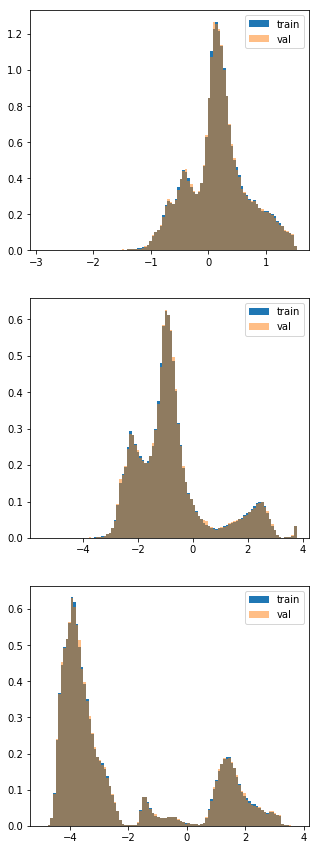

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for INDEX, ax in zip((0, 1, 2), axes):
    _, bins, _ = ax.hist(data_train.values[:, INDEX], bins=100, label="train", density=True)
    ax.hist(data_val.values[:, INDEX], bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## Building GAN

In [11]:
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]

data_test = data_test[in_columns+out_columns]

In [12]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    suffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [13]:
tf.reset_default_graph()

In [14]:
def get_dense(num_layers):
    return [ll.Dense(80, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 150

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(3) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(3) +
            [ll.Dense(OUT_DIM)])

In [15]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

In [16]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [17]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [18]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [19]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [20]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(2e-4, tf_iter, 100, 0.997)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [21]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [22]:
len(data_val)

92770

In [23]:
N_VAL = int(9e4)
validation_np = data_val.sample(N_VAL).values

In [24]:
data_val.sample(N_VAL).head()

,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,0,1,2
23143,-0.502797,-0.528525,-1000.0,-1000.0,0.0,-0.652614,-1.909161,1.462084
38890,0.225292,0.499860,0.0,0.0,-1.0,0.658619,2.793283,-3.583499
60756,0.282757,0.398087,0.0,0.0,-1.0,0.155331,-1.122469,-4.170167
89539,0.927856,0.572690,0.0,0.0,-1.0,0.781899,-2.402170,-3.661106
78757,-0.260589,0.119422,0.0,0.0,0.0,0.619390,-1.159335,-3.549203


In [25]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [26]:
tf.get_default_graph().finalize()

## Training GAN

In [27]:
# MODEL_NAME = "GAN_Kramer_dim3_bs1e4_n64-128_old_v2_pidd"
LOGDIR = "/mnt/tgaintseva/compression/tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(2e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

In [28]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                720       
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 243       
Total params: 13,923
Trainable params: 13,923
Non-trainable params: 0
_________________________________________________________________


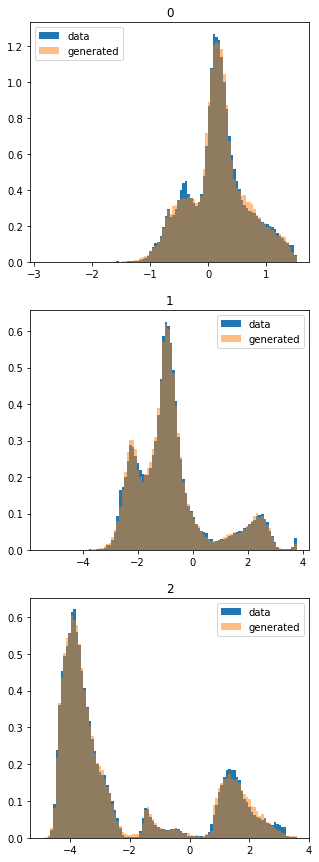

In [ ]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    for i in range(TOTAL_ITERATIONS):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, interation = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, interation)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: validation_np[:, :len(in_columns)],
                X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
            try:
                fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
                for INDEX, ax in zip((0, 1, 2), axes):
                    _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
                    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
                    ax.legend()
                    ax.set_title(out_columns[INDEX])
                plt.show()
                fig.savefig('./LHCb_PID_Compression/plots/{}.png'.format(MODEL_NAME))
            except:
                print("ups")
                weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
                continue
                
            test_writer.add_summary(test_summary, interation)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)

Look at the result distributions:

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e4_n80-150_old_pidd.ckpt


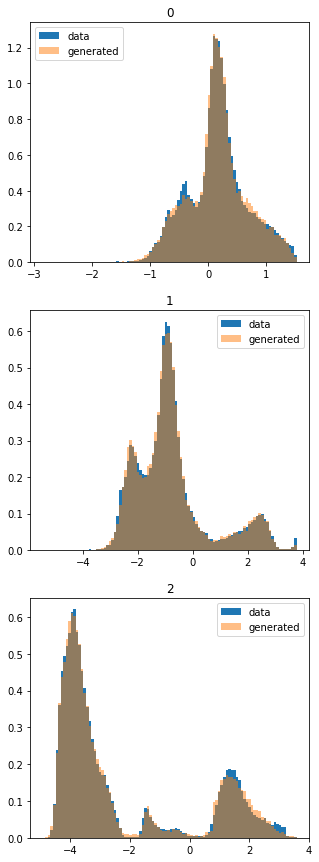

In [37]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: data_test.values[:, :len(in_columns)],
        X_train_input_tf2: data_test.values[:, :len(in_columns)], X_train_full_tf: data_test})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [38]:
test_transformed = scaler.inverse_transform(np.concatenate([test_generated, data_test.values[:, :len(in_columns)]], axis=1))
df_temp_enc = pd.DataFrame(test_transformed[:, :len(out_columns)], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = ['d']*len(df_temp_full_enc)
df_temp_full_enc.to_csv("./saved_dfs/{}.csv".format(MODEL_NAME), index=None)

## %%%%%%%%%%%%%%%%

Passing xgb encoded test data through gan

In [29]:
xgb_test_encoded = pd.read_csv('./data/ae_encoded_test_pid_{}_old.csv'.format(3))
xgb_test_encoded = xgb_test_encoded[xgb_test_encoded.pid==3]
y_test_dec = xgb_test_encoded["pid"].values
xgb_test_encoded = xgb_test_encoded.drop(["pid", "Unnamed: 0"], axis=1)

In [30]:
scaler = joblib.load(os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl") 
xgb_test_encoded = pd.DataFrame(scaler.transform(xgb_test_encoded[out_columns+in_columns].values),
                            columns=xgb_test_encoded[out_columns+in_columns].columns)

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e4_n80-150_old_pidd.ckpt


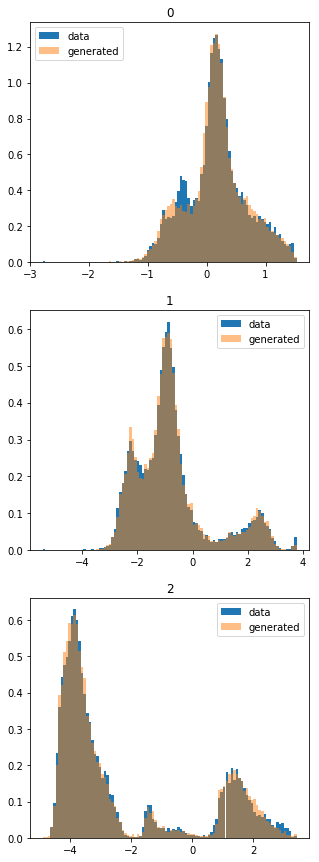

In [31]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: xgb_test_encoded[in_columns].values,
        X_train_input_tf2: xgb_test_encoded[in_columns].values, X_train_full_tf: xgb_test_encoded[in_columns+['0', '1', '2']]})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(xgb_test_encoded[str(INDEX)].values, bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [32]:
test_transformed = scaler.inverse_transform(np.concatenate([test_generated, xgb_test_encoded[in_columns].values], axis=1))
df_temp_enc = pd.DataFrame(test_transformed[:, :len(out_columns)], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, xgb_test_encoded[['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = ['d']*len(df_temp_full_enc)
df_temp_full_enc.to_csv("./data/AE_GAN_TEST_{}.csv".format(MODEL_NAME), index=None)